In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

print(tf.__version__)
# tf.get_logger().setLevel('INFO')

import logging
tf.get_logger().setLevel(logging.ERROR)


2.10.0


In [3]:
model = keras.models.load_model('ML_model/ANN_model')

2022-11-21 08:50:54.418160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-21 08:50:54.418568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-21 08:50:54.418639: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-21 08:50:54.418689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-21 08:50:54.418735: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [4]:
def inputsoutputsAllfiles(trainIterations, filepatharray, Timestepsize, maxtimestep):

    def xyz(iteration, filepath, Timestepsize, Timestep):

        Time = Timestep*Timestepsize 
        if Time%1 == 0:
            Time =int(Time)
        else: 
            Time = round(Time,2)
        my_file = open(filepath + str(Time) +"/solidsCellD_iteration"+str(iteration))
        string_list = my_file.readlines()
        index=18
        string_list = string_list[index+2:len(string_list)] 
        string_list = string_list[0:len(string_list)-4] 
        i=0
        for i in range(len(string_list)):
            string_list[i]=string_list[i].replace("(","")
            string_list[i]=string_list[i].replace(")","")
            string_list[i]=string_list[i].split()
        arr=np.array(string_list)
        arr= arr.astype(np.float64)
        x = arr[:,0]
        y = arr[:, 1]
        z = arr[:, 2]

        return x, y, z #, arr
        
      
    def maxIteration (Timestep, Timestepsize, filepath):
        Time = Timestep*Timestepsize
        Time = round(Time,2)   # Rounds to deicimal place
        file = filepath + "residual.dat"

        df = pd.read_csv(file)

        df.columns = ['One'] #Labels first Column

        df['One'] = df['One'].astype('string') # Converts to string

        new = df['One'].str.split(' ', expand = True) #splits into new dataframe on spaces

        df['TimeStep']= new[0].astype('float')  # labels new columns and inserts in dataframe
        df['solverPerfInitRes']= new[1].astype('float')  # labels new columns and inserts in dataframe
        df['residualvf']= new[2].astype('float')  # labels new columns and inserts in dataframe
        df['materialResidual']= new[3].astype('float')  # labels new columns and inserts in dataframe
        df["IterationNumber"]= new[4].astype('float') # labels new columns and inserts in dataframe

        df.drop(columns =['One'], inplace = True) #Removes original column

        array = np.array
        array = []

        for i in range(len(df)):        #loops through residual file
            if df['TimeStep'][i] == Time:   # Finds values for a timestep
                x = df['IterationNumber'][i]
                array.append(x)            # Creates arrays of iteration numbers
                
        max = np.max(array) # returns max of array
        max=int(max)
        return max
    
    def inputsoutputsAllTimesteps(trainIterations, filepath, Timestepsize):

        def inputsoutputsTimestep(trainIterations, filepath, Timestepsize, Timestep):

            max = maxIteration(Timestep, Timestepsize, filepath)

            x,y,z = xyz(1, filepath, Timestepsize, Timestep)
            matrix = np.array(np.vstack((x,y,z))) #Gives matrix a starting value which is removed later

            for i in range(0,trainIterations): # loops for each iteration up to trainIteration
                x,y,z = xyz(i,filepath, Timestepsize, Timestep)
                arr = np.vstack((x,y,z))  # gives array with x, y, z values for each iteration
                matrix = np.concatenate((matrix, arr))   # combines arrays

            inputs = matrix[3:,:] # removes initial value

            xmax, ymax, zmax = xyz(max, filepath, Timestepsize, Timestep)
            outputs = np.vstack((xmax,ymax,zmax)) # array of values at max iteration

            inputs = np.transpose(inputs)  # multiple columns : (x1, y1, z1, x2, y2, z2 ...)
            outputs = np.transpose(outputs)

            return inputs, outputs

        arrinputs = np.ones((1, trainIterations*3)) # first row to be removed after
        arroutputs = np.ones((1, 3))

        #combines inputs and outputs of all timesteps

        for Timestep in range(1,maxtimestep+1):
            inputs, outputs = inputsoutputsTimestep(trainIterations, filepath, Timestepsize, Timestep)
            arrinputs = np.vstack((arrinputs,inputs))
            arroutputs = np.vstack((arroutputs,outputs))

        arrinputs = arrinputs[1:,:] #removes oriinal row of ones
        arroutputs = arroutputs[1:,:]#removes oriinal row of ones

        outputs = arroutputs
        inputs = arrinputs

        return inputs, outputs   # Returns the inputs and outputs of All timesteps for one file

    arrinputs = np.ones((1, trainIterations*3))
    arroutputs = np.ones((1, 3))

    for i in range(0,len(filepatharray),1):
        inputs, outputs = inputsoutputsAllTimesteps(trainIterations, filepatharray[i], Timestepsize)
        arrinputs = np.vstack((arrinputs,inputs))
        arroutputs = np.vstack((arroutputs,outputs))

    arrinputs = arrinputs[1:,:] #removes oriinal row of ones
    arroutputs = arroutputs[1:,:]#removes oriinal row of ones

    outputs = arroutputs
    inputs = arrinputs

    return inputs, outputs


In [5]:
filepath1 = "../coarse_mesh/ellipticPlate/"

filepatharray = [filepath1]

In [7]:
trainIterations = input("Enter your training iteration value: ")
trainIterations = int(trainIterations)

Timestepsize = 1
maxtimestep = 1

inputs, outputs = inputsoutputsAllfiles(trainIterations, filepatharray, Timestepsize, maxtimestep)

In [8]:
# define model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

X = inputs
y = outputs

scalerI = StandardScaler().fit(X) #FitScaler
scalerO = StandardScaler().fit(y)


scaledX = scalerI.transform(X) # Scale X
scaledY = scalerO.transform(y)

In [9]:
# Ask for number of epocs

# answer_epochs = input("Number of epochs?: ")
# answer_epochs = int(answer_epochs)

answer_epochs = 500

In [10]:
# Ask if solidProperties is ready

# answer_solidsProp = input("Is solidProperties ready?: (y/n)")

answer_solidsProp = "y"

In [11]:
# Ask to train or load model

# answer_trainOrLoadModel = input("Train or load model?: (t/l) ")

answer_trainOrLoadModel = "l"

In [12]:

# if answer_trainOrLoadModel == ("t"):

#     model = Sequential()
#     model.add(Dense(200, input_dim=len(X[0,:]), 
#                     activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(150, 
#                     activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(50, 
#                     activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(3))

#     model.compile(loss='mean_squared_error', optimizer='adam')

#     # fit model
#     history = model.fit(scaledX, scaledY, epochs=answer_epochs, verbose=1)


#     # evaluate the model
#     train_mse = model.evaluate(scaledX, scaledY, verbose=0)


#     print('Train MSE: %f' % (train_mse))

#     # plot loss during training
#     plt.title('Loss / Mean Squared Error')
#     plt.plot(history.history['loss'], label='train')
#     plt.yscale('log')
#     # plt.plot(history.history['val_loss'], label='test')
#     plt.legend()
#     plt.show()

#     model.save('ML_model/ANN_model')

# elif answer_trainOrLoadModel == ("l"):
#     model = keras.models.load_model('ANN_model')


In [13]:
scaledPrediction = model.predict(scaledX)
prediction = scalerO.inverse_transform(scaledPrediction)

144/144 [==============================] - 0s 2ms/step


In [14]:

mean = np.hstack((scalerI.mean_, scalerO.mean_))
std = np.hstack((scalerI.scale_, scalerO.scale_))

names = np.array([])
for i in np.arange(1,len(mean)/3):

    names = np.append(
                        names, 
                        [
                            "X"+str(int(i)),
                            "Y"+str(int(i)),
                            "Z"+str(int(i))
                        ]      
                    )
names = np.append(
                    names,
                    [
                        "X_ouptut",
                        "Y_output",
                        "Z_output"
                    ]
                )

df = pd.DataFrame(data = np.vstack((mean, std)), columns = names, index = ["mean", "std"])

df

df.to_csv("ML_model/" + 'scalingData.csv')

In [15]:
#  Create mean and std strings
mean_string = str()
for i in np.arange(0,len(mean)/3):

    mean_string =  mean_string + "\t\t(" + str(mean[3*int(i)]) + "\t\t"+ str(mean[3*int(i) + 1]) + "\t\t"+ str(mean[3*int(i) + 2])+ ")\n"

std_string = str()
for i in np.arange(0,len(std)/3):

    std_string =  std_string + "\t\t(" + str(std[3*int(i)]) + "\t\t"+ str(std[3*int(i) + 1]) + "\t\t"+ str(std[3*int(i) + 2])+ ")\n"


In [16]:
# Save

import pickle
pickle.dump(scalerI, open('ML_model/scalerI.pkl','wb'))
pickle.dump(scalerO, open('ML_model/scalerO.pkl','wb'))


In [17]:
 #Save Data

 namesData = np.append(names, ["X_prediction", "Y_prediction", "Z_prediction"])
 
 df = pd.DataFrame(data = np.hstack((inputs, outputs, prediction)), index=None, columns = namesData)
 
 df.to_csv("ML_model/" + 'data.csv')

 df
 

,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,...,Z19,X20,Y20,Z20,X_ouptut,Y_output,Z_output,X_prediction,Y_prediction,Z_prediction
0,0.0,0.0,-5.894940e-06,-2.876100e-09,-5.404180e-07,-1.049900e-05,5.941770e-09,-4.341880e-07,-0.000014,1.599690e-08,...,-0.000053,2.194230e-07,3.339890e-06,-0.000055,0.000001,3.408810e-05,-0.000183,0.000001,3.429763e-05,-0.000182
1,0.0,0.0,-5.876910e-06,-8.861960e-09,-5.434090e-07,-1.046720e-05,1.708550e-08,-4.378690e-07,-0.000014,4.682030e-08,...,-0.000053,6.263470e-07,3.308380e-06,-0.000055,0.000004,3.373760e-05,-0.000182,0.000004,3.389757e-05,-0.000181
2,0.0,0.0,-5.842690e-06,-1.509500e-08,-5.468690e-07,-1.040470e-05,2.743580e-08,-4.439760e-07,-0.000014,7.630210e-08,...,-0.000052,1.040530e-06,3.251870e-06,-0.000054,0.000007,3.315660e-05,-0.000180,0.000007,3.325265e-05,-0.000179
3,0.0,0.0,-5.792400e-06,-2.203270e-08,-5.512570e-07,-1.031400e-05,3.660230e-08,-4.519690e-07,-0.000014,1.041430e-07,...,-0.000052,1.438990e-06,3.167190e-06,-0.000054,0.000009,3.227980e-05,-0.000177,0.000009,3.238761e-05,-0.000176
4,0.0,0.0,-5.727680e-06,-3.005830e-08,-5.552400e-07,-1.019770e-05,4.387380e-08,-4.604480e-07,-0.000014,1.293440e-07,...,-0.000051,1.822720e-06,3.059660e-06,-0.000053,0.000012,3.116000e-05,-0.000173,0.000012,3.132334e-05,-0.000173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,0.0,0.0,-6.572340e-07,-1.752720e-07,-4.249820e-08,-9.681760e-07,-3.719310e-07,-8.428210e-08,-0.000001,-5.522220e-07,...,-0.000003,-1.814020e-06,-3.709670e-07,-0.000003,-0.000003,-6.035800e-07,-0.000004,-0.000003,-7.037896e-07,-0.000004
4604,0.0,0.0,-6.503070e-07,-1.759780e-07,-3.265220e-08,-9.577710e-07,-3.720770e-07,-6.450710e-08,-0.000001,-5.515650e-07,...,-0.000003,-1.801490e-06,-2.795860e-07,-0.000003,-0.000003,-4.518770e-07,-0.000004,-0.000003,-5.554897e-07,-0.000004
4605,0.0,0.0,-6.459190e-07,-1.764500e-07,-2.325380e-08,-9.494850e-07,-3.725020e-07,-4.564520e-08,-0.000001,-5.514800e-07,...,-0.000003,-1.789450e-06,-1.944760e-07,-0.000003,-0.000003,-3.121640e-07,-0.000004,-0.000003,-4.166472e-07,-0.000004
4606,0.0,0.0,-6.421790e-07,-1.780580e-07,-1.408220e-08,-9.451440e-07,-3.728980e-07,-2.733930e-08,-0.000001,-5.508300e-07,...,-0.000003,-1.778350e-06,-1.140700e-07,-0.000003,-0.000003,-1.815440e-07,-0.000004,-0.000003,-2.859594e-07,-0.000004


In [18]:
 #Save Scaled Data

 namesData = np.append(names, ["X_prediction", "Y_prediction", "Z_prediction"])
 
 df = pd.DataFrame(data = np.hstack((scaledX, scaledY, scaledPrediction)), index=None, columns = namesData)
 
 df.to_csv("ML_model/" + 'dataScaled.csv')

 df

,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,...,Z19,X20,Y20,Z20,X_ouptut,Y_output,Z_output,X_prediction,Y_prediction,Z_prediction
0,0.0,0.0,-1.213653,0.677750,-1.448071,-1.357519,0.468011,-0.669001,-1.395436,0.354177,...,-1.730784,0.158480,1.543048,-1.744862,0.163570,3.186601,-2.416259,0.156292,3.205968,-2.403413
1,0.0,0.0,-1.202490,0.643090,-1.461641,-1.346013,0.505848,-0.681148,-1.383177,0.422973,...,-1.718192,0.305705,1.529952,-1.732311,0.422139,3.154205,-2.396099,0.405295,3.168991,-2.385746
2,0.0,0.0,-1.181304,0.606999,-1.477340,-1.323399,0.540992,-0.701300,-1.360271,0.488774,...,-1.692138,0.455557,1.506466,-1.706045,0.691265,3.100503,-2.351296,0.668867,3.109381,-2.342365
3,0.0,0.0,-1.150169,0.566827,-1.497249,-1.290580,0.572116,-0.727675,-1.327014,0.550912,...,-1.653904,0.599719,1.471273,-1.667543,0.939568,3.019460,-2.286891,0.917964,3.029425,-2.282078
4,0.0,0.0,-1.110100,0.520356,-1.515321,-1.248499,0.596805,-0.755653,-1.284427,0.607159,...,-1.604581,0.738553,1.426583,-1.617865,1.174979,2.915957,-2.204555,1.159136,2.931055,-2.204936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,0.0,0.0,2.029073,-0.320479,0.811089,2.091048,-0.815021,0.485607,2.086478,-0.914042,...,1.837359,-0.577219,0.000800,1.825838,-0.283066,-0.019954,1.423524,-0.292758,-0.029216,1.423676
4604,0.0,0.0,2.033362,-0.324567,0.855762,2.094813,-0.815517,0.550860,2.090248,-0.912576,...,1.840026,-0.572685,0.038778,1.828491,-0.279981,-0.005932,1.424780,-0.289582,-0.015509,1.424324
4605,0.0,0.0,2.036079,-0.327300,0.898404,2.097811,-0.816960,0.613100,2.093224,-0.912386,...,1.842222,-0.568329,0.074150,1.830652,-0.277183,0.006982,1.425792,-0.286601,-0.002676,1.424734
4606,0.0,0.0,2.038394,-0.336611,0.940018,2.099381,-0.818305,0.673505,2.095090,-0.910936,...,1.843844,-0.564313,0.107567,1.832261,-0.274629,0.019055,1.426560,-0.283522,0.009404,1.424651


4608

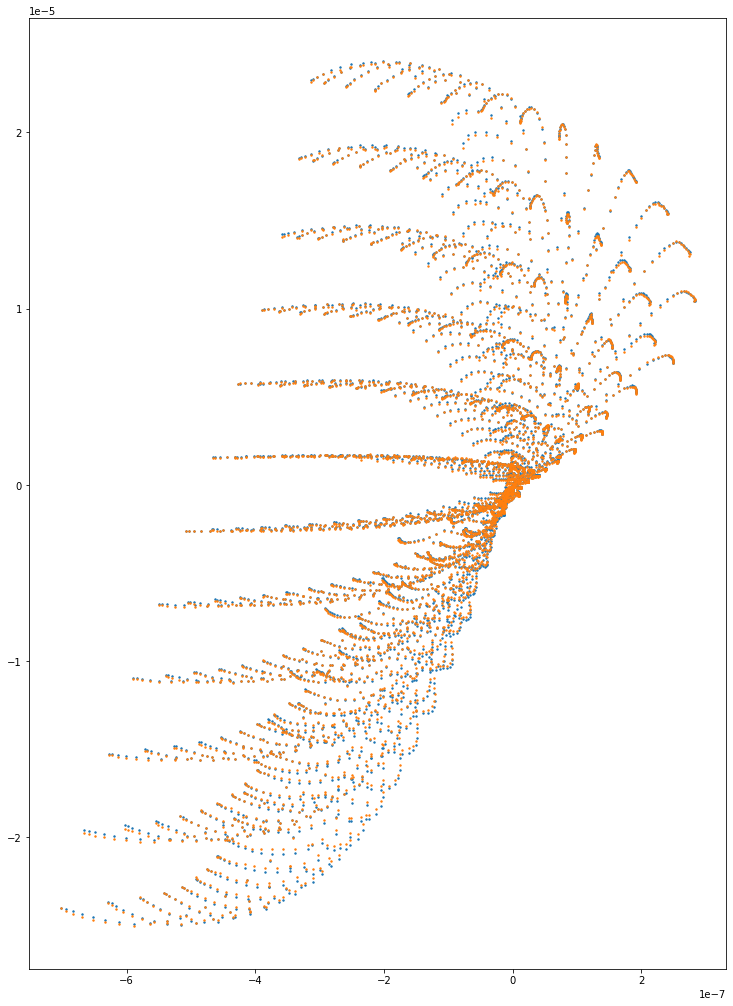

In [19]:
f=15

fig = plt.figure(figsize=(12.5, 17.5))
plt.scatter(inputs[:,3],outputs[:,0], s= 2)
plt.scatter(inputs[:,3],prediction[:,0],s = 2)
len(inputs[:,0])



In [20]:
train_mse = model.evaluate(scaledX, scaledY, verbose=0)


print('Train MSE: %f' % (train_mse))

Train MSE: 0.000058


Total speed up (%): 34%


## END FOR NOW